In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys

sys.path.append("../")

from src.data_processing import DataProcessing
from src.visualization import visualize_transfer_network

pd.options.display.max_columns = 100

# Data Loading and processing


In [13]:
df = pd.read_csv("../data/transfers.csv")
dp = DataProcessing(df)
df = dp.process_data()

In [14]:
df_season = df[df["season"] == 2021]

In [15]:
di_graph = nx.from_pandas_edgelist(
    df_season,
    source="team_name",
    target="counter_team_name",
    edge_attr=["total_fee", "is_loan"],
    create_using=nx.DiGraph,
)

# Edge prediction for the directed graph


In [28]:
from src.edge_pred import TransferGraphDataProcessor, TransferEdgePrediction

In [29]:
processor = TransferGraphDataProcessor(di_graph, test_size=0.2)
train_graph, test_edges, test_non_edges = processor.split_edges()

print(
    f"Train graph has {train_graph.number_of_nodes()} nodes and {train_graph.number_of_edges()} edges"
)
print(
    f"Test set has {len(test_edges)} positive edges and {len(test_non_edges)} negative edges"
)

processor.extract_node_features(method="structural")
X_train, y_train, X_test, y_test, feature_names = processor.prepare_training_data()

Train graph has 963 nodes and 2337 edges
Test set has 585 positive edges and 585 negative edges
Generating negative examples for training...
Train w/ 2337 positive, 2337 neg
Preparing training data...


100%|██████████| 2337/2337 [00:10<00:00, 217.44it/s]


Preparing test data...


100%|██████████| 585/585 [00:02<00:00, 216.98it/s]


In [30]:
# Train and evaluate edge prediction models
predictor = TransferEdgePrediction()
predictor.train_models(X_train, y_train, feature_names)

# Evaluate models
results = predictor.evaluate_models(X_test, y_test)
print("Model evaluation results:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Training models...
Model evaluation results:

logistic_regression:
  accuracy: 0.8085
  precision: 0.8324
  recall: 0.7726
  f1: 0.8014
  roc_auc: 0.9137

random_forest:
  accuracy: 0.7615
  precision: 0.8214
  recall: 0.6684
  f1: 0.7370
  roc_auc: 0.8675

gradient_boosting:
  accuracy: 0.7538
  precision: 0.8207
  recall: 0.6496
  f1: 0.7252
  roc_auc: 0.8870


In [31]:
# Get node pairs to predict
node_pairs = processor.sample_node_pairs_for_prediction(sample_size=1000)

# Predict top potential transfers
top_transfers = predictor.predict_top_edges(node_pairs, processor, top_k=5)
print("\nTop 5 predicted transfers:")
for u, v, prob in top_transfers:
    print(f"{u} -> {v}: {prob:.4f}")

Predicting edge probabilities...


100%|██████████| 1000/1000 [00:04<00:00, 206.43it/s]


Top 5 predicted transfers:
ACF Fiorentina -> 1.FSV Mainz 05: 0.9845
SL Benfica -> OGC Nice: 0.9798
Inter Milan -> Pordenone Calcio: 0.9795
SSC Napoli -> PSV Eindhoven: 0.9759
Norwich City -> CD Mirandés: 0.9695


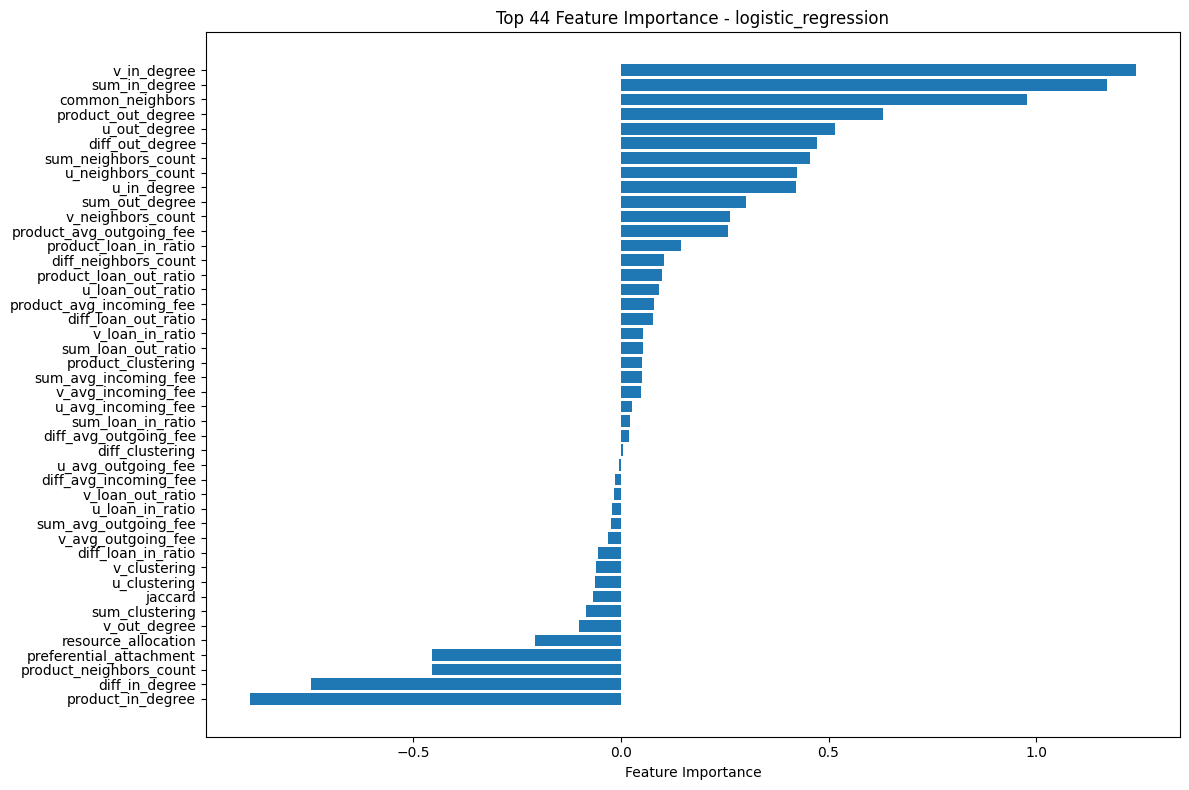

In [41]:
predictor.plot_feature_importance("logistic_regression")